In [1]:
# Imports and useful definitions
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

%matplotlib inline
random.seed(156)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df_depots = pd.read_csv("raw_data/town_state.csv")

In [3]:
# Now a look at the Depots table
display("Dimensions of Stores table : " + str(df_depots.shape))
display("DF head : ")
display(df_depots.head())

'Dimensions of Stores table : (790, 3)'

'DF head : '

,Agencia_ID,Town,State
0,1110,2008 AG. LAGO FILT,"MÉXICO, D.F."
1,1111,2002 AG. AZCAPOTZALCO,"MÉXICO, D.F."
2,1112,2004 AG. CUAUTITLAN,ESTADO DE MÉXICO
3,1113,2008 AG. LAGO FILT,"MÉXICO, D.F."
4,1114,2029 AG.IZTAPALAPA 2,"MÉXICO, D.F."


In [4]:
# Rename columns in english for easier further use
df_depots.columns = ["depot_id", "city", "state"]
display(df_depots.head())

,depot_id,city,state
0,1110,2008 AG. LAGO FILT,"MÉXICO, D.F."
1,1111,2002 AG. AZCAPOTZALCO,"MÉXICO, D.F."
2,1112,2004 AG. CUAUTITLAN,ESTADO DE MÉXICO
3,1113,2008 AG. LAGO FILT,"MÉXICO, D.F."
4,1114,2029 AG.IZTAPALAPA 2,"MÉXICO, D.F."


In [5]:
# Check for missing values?
display("There are " + str(np.count_nonzero(df_depots.isnull())) + " rows with missing values")

# Handle duplicates
boolDupli = df_depots["depot_id"].duplicated(keep = False)
display("There are " + str(df_depots[boolDupli].shape[0] / 2) + " duplicate Depot IDs")

'There are 0 rows with missing values'

'There are 0.0 duplicate Depot IDs'

In [6]:
df_depots.city.value_counts(dropna = False)

2013 AG. MEGA NAUCALPAN                8
2011 AG. SAN ANTONIO                   7
2355 JALAPA I                          7
2573 TIJUANA GATO BRONCO               6
2322 ZAMORA MADERO                     6
2468 MATAMOROS BIMBO                   6
2269 PUERTO VALLARTA BIMBO             6
2036 APIZACO MARINELA                  6
2402 TUXTLA                            6
2161 IRAPUATO GUADALUPE                6
2290 DURANGO BIMBO                     6
2029 AG.IZTAPALAPA 2                   6
2505 TORREON                           6
2465 LAREDO                            6
2555 ENSENADA II                       6
2396 RUIZ CORTINEZ                     6
2034 ACAPULCO COSTERA                  5
2416 PACHUCA II                        5
2293 GRANJAS MARINELA                  5
2174 SAN MIGUEL DE ALLENDE             5
2520 HERMOSILLO SUR                    5
2563 MEXICALI PONIENTE                 5
2272 SAN LUIS REY                      5
2480 VICTORIA BIMBO                    5
2300 LEON MILENI

In [7]:
# We will infer several features like total sales in pesos from trains.csv
df_train = pd.read_csv("raw_data/train.csv",
                       dtype = {'Semana' : 'int8', 'Agencia_ID' :'int32', 'Canal_ID' : 'int32', 'Ruta_SAK' : 'int32',
                                'Cliente-ID' : 'int32', 'Producto_ID':'int32', 'Venta_hoy':'float32', 'Venta_uni_hoy': 'int32', 
                                'Dev_uni_proxima':'int32', 'Dev_proxima':'float32', 'Demanda_uni_equil':'int32'})
df_train.columns = ["week", "depot_id", "channel_id", "route_id", "store_id", "product_id", "sales_nb", "sales_pesos", 
                    "returns_nb", "returns_pesos", "adj_demand"]
total_sales_nb = df_train.groupby("depot_id")["sales_nb"].sum().to_frame()
df_depots = pd.merge(left = df_depots, right = total_sales_nb, how = "left", left_on = "depot_id", right_index = True)
df_depots.rename(columns = {"sales_nb" : "total_sales_nb"}, inplace = True)

total_sales_pesos = df_train.groupby("depot_id")["sales_pesos"].sum().to_frame()
df_depots = pd.merge(left = df_depots, right = total_sales_pesos, how = "left", left_on = "depot_id", right_index = True)
df_depots.rename(columns = {"sales_pesos" : "total_sales_pesos"}, inplace = True)

total_returns_nb = df_train.groupby("depot_id")["returns_nb"].sum().to_frame()
df_depots = pd.merge(left = df_depots, right = total_returns_nb, how = "left", left_on = "depot_id", right_index = True)
df_depots.rename(columns = {"returns_nb" : "total_returns_nb"}, inplace = True)

total_returns_pesos = df_train.groupby("depot_id")["returns_pesos"].sum().to_frame()
df_depots = pd.merge(left = df_depots, right = total_returns_pesos, how = "left", left_on = "depot_id", right_index = True)
df_depots.rename(columns = {"returns_pesos" : "total_returns_pesos"}, inplace = True)

total_adj_demand = df_train.groupby("depot_id")["adj_demand"].sum().to_frame()
df_depots = pd.merge(left = df_depots, right = total_adj_demand, how = "left", left_on = "depot_id", right_index = True)
df_depots.rename(columns = {"adj_demand" : "total_adj_demand"}, inplace = True)

In [8]:
display(df_depots.sort_values("total_sales_pesos", ascending = False).head(10))

,depot_id,city,state,total_sales_nb,total_sales_pesos,total_returns_nb,total_returns_pesos,total_adj_demand
16,1129,2011 AG. SAN ANTONIO,"MÉXICO, D.F.",3748791.000,66163784.000,19644.000,354812.656,3731729.000
4,1114,2029 AG.IZTAPALAPA 2,"MÉXICO, D.F.",3498170.000,62420320.000,150779.000,2480404.750,3363796.000
22,1142,2013 AG. MEGA NAUCALPAN,ESTADO DE MÉXICO,3484305.000,62069568.000,35968.000,571478.500,3452405.000
37,1168,2092 AG. SANTA CLARA AUTOSERVICIOS,ESTADO DE MÉXICO,2642994.000,46739792.000,31408.000,503239.469,2614745.000
316,1911,2309 NORTE,JALISCO,5355617.000,40226636.000,87481.000,761811.062,5298372.000
526,4061,2517 SENDERO AUTOSERVICIO,NUEVO LEÓN,1793102.000,31862378.000,86967.000,1453991.000,1717715.000
86,1312,2278 ZAPOPAN BIMBO,JALISCO,3901226.000,31410684.000,48758.000,451032.438,3867069.000
14,1126,2017 AG. SANTA CLARA,ESTADO DE MÉXICO,3241796.000,30947328.000,34158.000,384503.625,3214769.000
110,1351,2252 AGUASCALIENTES SIGLO XXI,AGUASCALIENTES,4103035.000,30911018.000,44234.000,360760.906,4075131.000
10,1121,2016 AG. SAN LORENZO,"MÉXICO, D.F.",3284010.000,29898290.000,28756.000,303294.625,3262501.000


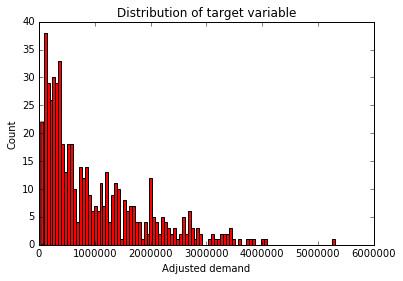

In [10]:
target = df_depots["total_adj_demand"].dropna().tolist()
plt.hist(target, bins = 100, color = "red")
plt.title("Distribution of target variable")
plt.xlabel("Adjusted demand")
plt.ylabel("Count")
plt.show()

In [11]:
# Remove rows with NAs
df_depots.dropna(axis = 0, how = "any", inplace = True)
display("Dimensions of Depots table are now : " + str(df_depots.shape))
display(df_depots.head())

'Dimensions of Depots table are now : (552, 8)'

,depot_id,city,state,total_sales_nb,total_sales_pesos,total_returns_nb,total_returns_pesos,total_adj_demand
0,1110,2008 AG. LAGO FILT,"MÉXICO, D.F.",877675.000,9274674.000,39900.000,214072.766,874523.000
1,1111,2002 AG. AZCAPOTZALCO,"MÉXICO, D.F.",2720400.000,24070592.000,25231.000,264672.438,2701427.000
2,1112,2004 AG. CUAUTITLAN,ESTADO DE MÉXICO,1959534.000,16591688.000,23924.000,231897.391,1942114.000
3,1113,2008 AG. LAGO FILT,"MÉXICO, D.F.",1442999.000,12094484.000,11865.000,117754.383,1434414.000
4,1114,2029 AG.IZTAPALAPA 2,"MÉXICO, D.F.",3498170.000,62420320.000,150779.000,2480404.750,3363796.000


In [14]:
# Remove non-numeric columns
df_depots.drop(["city", "state"], axis = 1, inplace = True)
display(df_depots.head())

,depot_id,total_sales_nb,total_sales_pesos,total_returns_nb,total_returns_pesos,total_adj_demand
0,1110,877675.000,9274674.000,39900.000,214072.766,874523.000
1,1111,2720400.000,24070592.000,25231.000,264672.438,2701427.000
2,1112,1959534.000,16591688.000,23924.000,231897.391,1942114.000
3,1113,1442999.000,12094484.000,11865.000,117754.383,1434414.000
4,1114,3498170.000,62420320.000,150779.000,2480404.750,3363796.000


In [15]:
# Use store_id as the index
df_depots.set_index("depot_id", inplace = True)
display(df_depots.head())

,total_sales_nb,total_sales_pesos,total_returns_nb,total_returns_pesos,total_adj_demand
depot_id,,,,,
1110,877675.000,9274674.000,39900.000,214072.766,874523.000
1111,2720400.000,24070592.000,25231.000,264672.438,2701427.000
1112,1959534.000,16591688.000,23924.000,231897.391,1942114.000
1113,1442999.000,12094484.000,11865.000,117754.383,1434414.000
1114,3498170.000,62420320.000,150779.000,2480404.750,3363796.000


In [23]:
# Separate depots in groups using K-Means
estimator = KMeans(n_clusters = 12)
estimator.fit(df_depots)

display(estimator.cluster_centers_)

array([[  1.91731698e+06,   1.71983084e+07,   3.15820952e+04,
          3.05325851e+05,   1.89619843e+06,   1.00000000e+00],
       [  1.40700109e+05,   1.43762450e+06,   6.27484158e+03,
          5.62438430e+04,   1.36042139e+05,   8.00000000e+00],
       [  3.57708867e+06,   6.35512240e+07,   6.87970000e+04,
          1.13556530e+06,   3.51597667e+06,   2.00000000e+00],
       [  1.27095436e+06,   1.11277183e+07,   2.61845410e+04,
          2.06369356e+05,   1.25587852e+06,   4.24590164e+00],
       [  2.64735565e+06,   2.38303738e+07,   3.94843500e+04,
          3.85886578e+05,   2.62053995e+06,   5.00000000e+00],
       [  5.74877529e+05,   5.92118718e+06,   9.71250588e+03,
          9.97439170e+04,   5.68953976e+05,   5.29411765e+00],
       [  3.99930550e+06,   4.34832140e+07,   5.94445000e+04,
          6.32525266e+05,   3.95655850e+06,   9.00000000e+00],
       [  8.70792804e+05,   8.50471121e+06,   1.42677143e+04,
          1.38809298e+05,   8.61843714e+05,   4.12500000e+00],


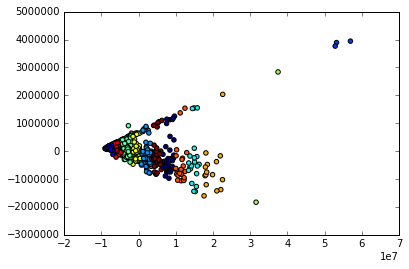

In [24]:
# Quick plotting to check if the clustering went right
labels = estimator.labels_
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(df_depots) 
plt.scatter(x = plot_columns[:,0], y = plot_columns[:,1], c = labels) 
plt.show()

In [25]:
df_depots["cluster"] = labels
display(df_depots.groupby("cluster").describe())

total_adj_demand  total_returns_nb  total_returns_pesos  \
cluster                                                                  
0       count            42.000            42.000               42.000   
        mean        1896198.429         31582.095           305325.875   
        std          420359.193         13616.515           169629.649   
        min          894446.000           627.000             7490.220   
        25%         1793123.500         26771.000           236603.395   
        50%         2028584.500         33979.000           300612.781   
        75%         2159924.250         36231.250           333344.695   
        max         2436908.000         65602.000          1078573.750   
1       count           100.000           100.000              100.000   
        mean         134709.490          6068.180            54499.680   
        std           63234.924          6902.335            58876.443   
        min           31973.000            17.000              305.490   
        25%           88386.750          1108.750            11076.617   
        50%          123113.000          3863.000            36296.721   
        75%          178892.500          8828.750            80260.299   
        max          387921.000         37713.000           302613.219   
2       count             3.000             3.000                3.000   
        mean        3515976.667         68797.000          1135565.375   
        std          192027.838         71466.107          1169692.659   
        min         3363796.000         19644.000           354812.656   
        25%         3408100.500         27806.000           463145.578   
        50%         3452405.000         35968.000           571478.500   
        75%         3592067.000         93373.500          1525941.625   
        max         3731729.000        150779.000          2480404.750   
3       count            61.000            61.000               61.000   
        mean        1255878.525         26184.541           206369.375   
        std          313740.834         39801.381           153787.013   
        min          549160.000             0.000                0.000   
        25%         1137337.000         14459.000           138578.812   
        50%         1316542.000         19019.000           164984.875   
...                         ...               ...                  ...   
8       std          574479.851         17703.470           276730.035   
        min         1717715.000         25890.000           292969.062   
        25%         3159363.500         38164.000           380802.109   
        50%         3305349.000         51142.000           477153.562   
        75%         3676942.000         64742.500           518914.234   
        max         4075131.000         86967.000          1453991.000   
9       count            22.000            22.000               22.000   
        mean        2392664.500         39447.773           380878.438   
        std          487667.759         11882.450           137334.628   
        min         1093032.000          9068.000           154374.656   
        25%         2292581.250         37575.750           300172.961   
        50%         2533050.500         42280.500           399155.484   
        75%         2683158.000         48327.500           469895.633   
        max         2879791.000         53929.000           769436.938   
10      count           104.000           104.000              104.000   
        mean         332914.221          8198.865            77519.508   
        std          103415.241         10300.430            87174.035   
        min          147352.000             0.000                0.000   
        25%          263923.750          1660.750            16458.920   
        50%          328149.500          5213.500            51281.666   
        75%          393770.750          9736.000           109728.586   
        max        

In [26]:
display(df_depots.sort_values("total_sales_pesos", ascending = False).head(10))
display(df_depots.sort_values("total_sales_pesos", ascending = False).tail(10))

,total_sales_nb,total_sales_pesos,total_returns_nb,total_returns_pesos,total_adj_demand,cluster
depot_id,,,,,,
1129,3748791.000,66163784.000,19644.000,354812.656,3731729.000,2
1114,3498170.000,62420320.000,150779.000,2480404.750,3363796.000,2
1142,3484305.000,62069568.000,35968.000,571478.500,3452405.000,2
1168,2642994.000,46739792.000,31408.000,503239.469,2614745.000,6
1911,5355617.000,40226636.000,87481.000,761811.062,5298372.000,6
4061,1793102.000,31862378.000,86967.000,1453991.000,1717715.000,8
1312,3901226.000,31410684.000,48758.000,451032.438,3867069.000,8
1126,3241796.000,30947328.000,34158.000,384503.625,3214769.000,8
1351,4103035.000,30911018.000,44234.000,360760.906,4075131.000,8


,total_sales_nb,total_sales_pesos,total_returns_nb,total_returns_pesos,total_adj_demand,cluster
depot_id,,,,,,
1991,67345.000,603000.938,14038.000,128004.328,55106.000,1
2068,69693.000,569230.000,2183.000,19559.230,69693.000,1
1989,65714.000,559308.375,5656.000,50085.129,60817.000,1
2621,66197.000,540114.938,1876.000,16083.220,65878.000,1
1983,64773.000,530384.000,13775.000,112617.594,53667.000,1
1564,65460.000,523237.344,3949.000,32658.830,62058.000,1
1992,55076.000,517014.531,5369.000,49747.590,50287.000,1
1990,54915.000,445318.031,10184.000,83980.938,46769.000,1
2618,38090.000,322177.719,5573.000,47963.828,33104.000,1
